# Thresholding

In [1]:
import zarr
import zarr.storage
import fsspec
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.signal import stft

In [2]:
shot_id = 23447
endpoint="https://s3.echo.stfc.ac.uk"
fs = fsspec.filesystem(
    protocol='simplecache',
    target_protocol="s3",
    target_options=dict(anon=True, endpoint_url=endpoint)
)

url = f"s3://mast/level2/shots/{shot_id}.zarr"
store = zarr.storage.FSStore(fs=fs, url=url)

In [3]:
root = zarr.open_group(store, mode='r')
mirnov = xr.open_zarr(store, group="magnetics")
mirnov

<xarray.Dataset> Size: 32MB
Dimensions:                                   (b_field_pol_probe_cc_channel: 5,
                                               time_mirnov: 261200,
                                               b_field_pol_probe_ccbv_channel: 40,
                                               time: 2612,
                                               b_field_pol_probe_obr_channel: 18,
                                               b_field_pol_probe_obv_channel: 18,
                                               b_field_pol_probe_omv_channel: 3,
                                               b_field_tor_probe_cc_channel: 3,
                                               b_field_tor_probe_saddle_field_channel: 12,
                                               time_saddle: 26120,
                                               b_field_tor_probe_saddle_voltage_channel: 12,
                                               flux_loop_channel: 15)
Coordinates:
  * b_field_pol_probe_cc_channel              (b_field_pol_probe_cc_channel) <U13 260B ...
  * b_field_pol_probe_ccbv_channel            (b_field_pol_probe_ccbv_channel) <U10 2kB ...
  * b_field_pol_probe_obr_channel             (b_field_pol_probe_obr_channel) <U9 648B ...
  * b_field_pol_probe_obv_channel             (b_field_pol_probe_obv_channel) <U9 648B ...
  * b_field_pol_probe_omv_channel             (b_field_pol_probe_omv_channel) <U11 132B ...
  * b_field_tor_probe_cc_channel              (b_field_tor_probe_cc_channel) <U13 156B ...
  * b_field_tor_probe_saddle_field_channel    (b_field_tor_probe_saddle_field_channel) <U11 528B ...
  * b_field_tor_probe_saddle_voltage_channel  (b_field_tor_probe_saddle_voltage_channel) <U15 720B ...
  * flux_loop_channel                         (flux_loop_channel) <U12 720B '...
  * time                                      (time) float64 21kB -0.099 ... ...
  * time_mirnov                               (time_mirnov) float64 2MB -0.09...
  * time_saddle                               (time_saddle) float64 209kB -0....
Data variables:
    b_field_pol_probe_cc_field                (b_field_pol_probe_cc_channel, time_mirnov) float64 10MB ...
    b_field_pol_probe_ccbv_field              (b_field_pol_probe_ccbv_channel, time) float64 836kB ...
    b_field_pol_probe_obr_field               (b_field_pol_probe_obr_channel, time) float64 376kB ...
    b_field_pol_probe_obv_field               (b_field_pol_probe_obv_channel, time) float64 376kB ...
    b_field_pol_probe_omv_voltage             (b_field_pol_probe_omv_channel, time_mirnov) float64 6MB ...
    b_field_tor_probe_cc_field                (b_field_tor_probe_cc_channel, time_mirnov) float64 6MB ...
    b_field_tor_probe_saddle_field            (b_field_tor_probe_saddle_field_channel, time_saddle) float64 3MB ...
    b_field_tor_probe_saddle_voltage          (b_field_tor_probe_saddle_voltage_channel, time_saddle) float64 3MB ...
    flux_loop_flux                            (flux_loop_channel, time) float64 313kB ...
    ip                                        (time) float64 21kB ...
Attributes:
    description:  
    imas:         magnetics
    label:        Plasma Current
    name:         magnetics
    uda_name:     AMC_PLASMA CURRENT
    units:        A

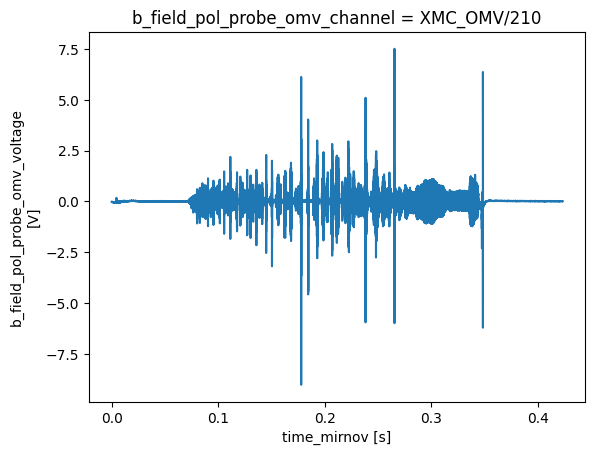

In [4]:
ds = mirnov['b_field_pol_probe_omv_voltage'].isel(b_field_pol_probe_omv_channel=1)
ds.plot()

##  Short-Time Fourier Transform (STFT)

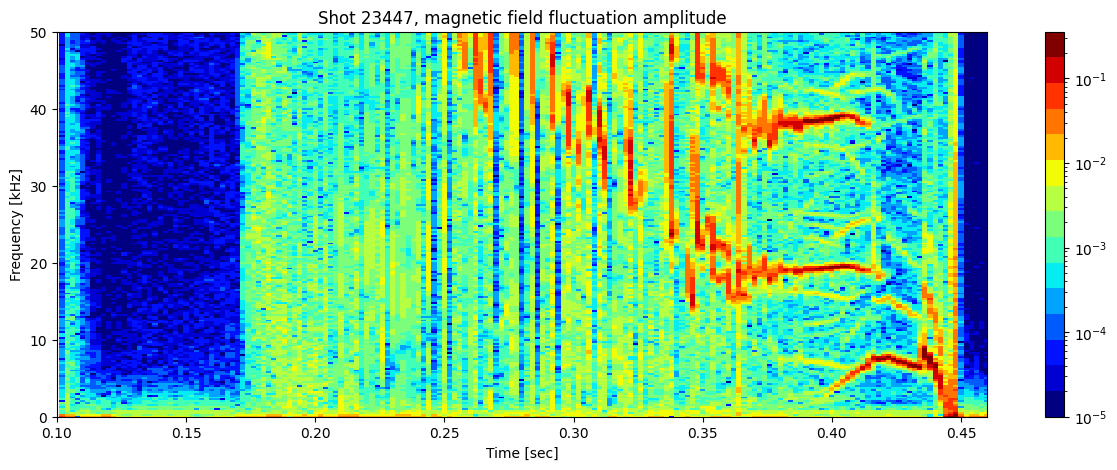

In [26]:
nperseg = 2000  # Number of points per segment
nfft = 2000  # Number of FFT points

# Compute the Short-Time Fourier Transform (STFT)
sample_rate = 1/(ds.time_mirnov[1] - ds.time_mirnov[0])
f, t, Zxx = stft(ds, fs=int(sample_rate), nperseg=nperseg, nfft=nfft)

fig, ax = plt.subplots(figsize=(15, 5))
cax = ax.pcolormesh(t, f/1000, np.abs(Zxx), shading='nearest', cmap=plt.get_cmap('jet', 15), norm=LogNorm(vmin=1e-5))
ax.set_ylim(0, 50)
ax.set_title(f'Shot {shot_id}, magnetic field fluctuation amplitude')
ax.set_ylabel('Frequency [kHz]')
ax.set_xlabel('Time [sec]')
ax.set_xlim(0.1, 0.46)
plt.colorbar(cax, ax=ax)

### Inspect amplitude distribution

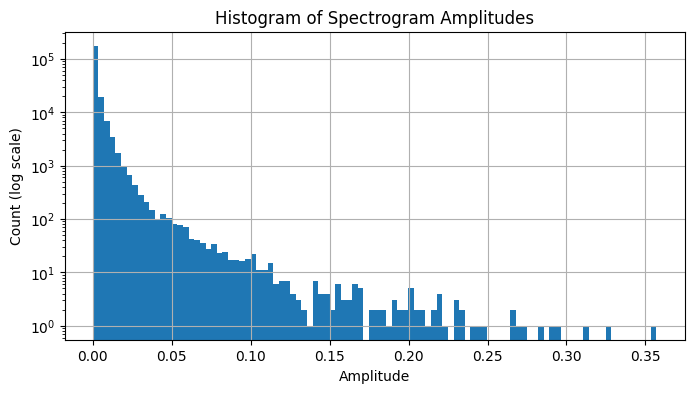

In [12]:
plt.figure(figsize=(8,4))
plt.hist(np.abs(Zxx.flatten()), bins=100, log=True)
plt.xlabel('Amplitude')
plt.ylabel('Count (log scale)')
plt.title('Histogram of Spectrogram Amplitudes')
plt.grid(True)

In [ ]:
def visualise_thresholded_spectrogram(t, f, binary_mask):
    """
    Visualise the binary mask of the spectrogram.
    """
    fig, ax = plt.subplots(figsize=(15, 5))
    cax = ax.pcolormesh(t, f/1000, binary_mask, shading='nearest', cmap='gray_r')
    #ax.set_ylim(0, 50)
    #ax.set_xlim(0.1, 0.46)
    ax.set_title(f'Shot {shot_id}, Binary Thresholded Modes')
    ax.set_ylabel('Frequency [kHz]')
    ax.set_xlabel('Time [sec]')
    plt.colorbar(cax, ax=ax, label='Mode presence (binary)')

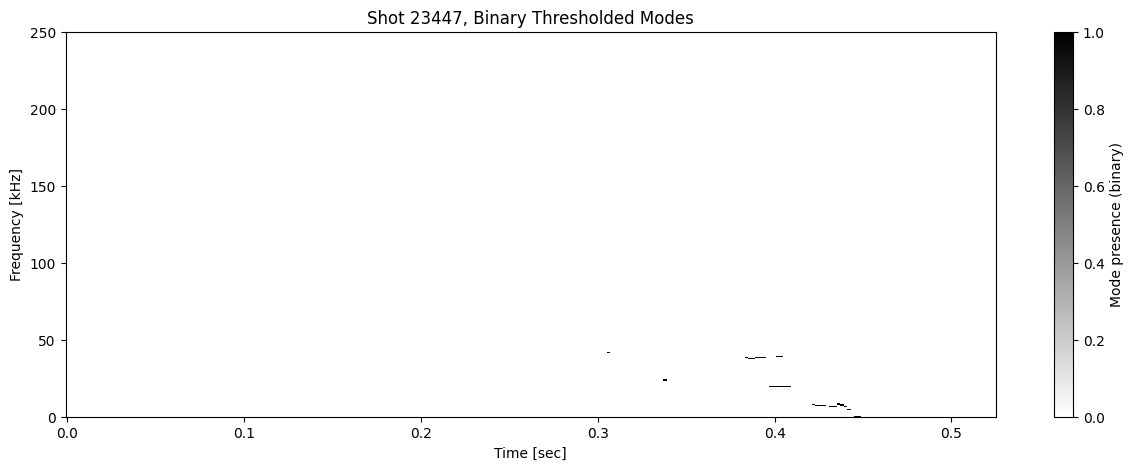

In [ ]:
# Define a threshold (e.g., percentile-based threshold)
threshold = 0.15 #np.percentile(np.abs(Zxx), 50)  # top 5% amplitudes

# Create binary mask based on threshold
binary_mask = np.abs(Zxx) >= threshold
visualise_thresholded_spectrogram(t, f, binary_mask)

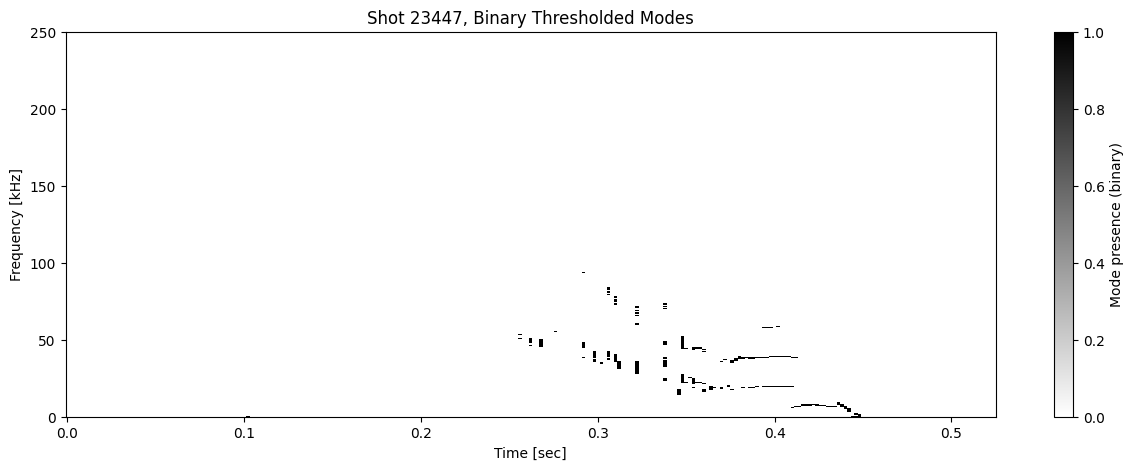

In [24]:
# Define a threshold (e.g., percentile-based threshold)
threshold = 0.05 #np.percentile(np.abs(Zxx), 50)  # top 5% amplitudes

# Create binary mask based on threshold
binary_mask = np.abs(Zxx) >= threshold
visualise_thresholded_spectrogram(t, f, binary_mask)

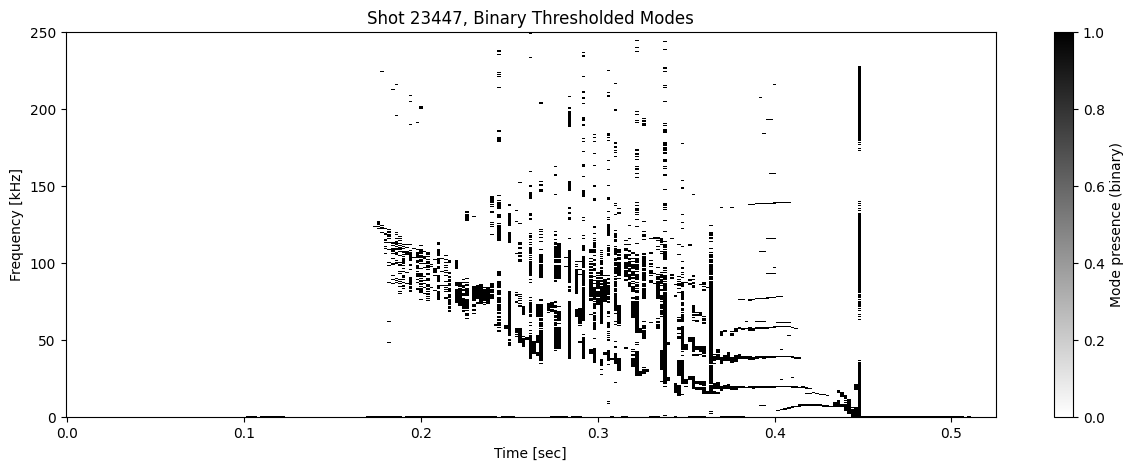

In [25]:
# Define a threshold (e.g., percentile-based threshold)
threshold = 0.01 #np.percentile(np.abs(Zxx), 50)  # top 5% amplitudes

# Create binary mask based on threshold
binary_mask = np.abs(Zxx) >= threshold
visualise_thresholded_spectrogram(t, f, binary_mask)